# Titanic Random Forest


First Kaggle competition entry.
Using the two kernels below as guidance.
- https://www.kaggle.com/goldens/classification-81-3-with-simple-model-nested-cv
- https://www.kaggle.com/yassineghouzam/titanic-top-4-with-ensemble-modeling

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

In [13]:
training_filename = 'train.csv'
test_filename = 'test.csv'

In [14]:
df_raw_train = pd.read_csv('train.csv')
df_raw_test = pd.read_csv('test.csv')

## Joining test and train
Joining our test and train data has a number of advantages.
1. Allows for processing both our data sets in the same manner.
2. Grants insight across the whole range of data we are working with.
3. Ensures that we maintain the same number and type of features.


In [17]:
train_len = len(df_raw_train)
df_raw = pd.concat(objs=[df_raw_train, df_raw_test], axis=0, sort=False).reset_index(drop=True)

## Inspection
Start by taking a look at the data.

In [18]:
df_raw.dtypes.sort_values()

PassengerId      int64
Pclass           int64
SibSp            int64
Parch            int64
Survived       float64
Age            float64
Fare           float64
Name            object
Sex             object
Ticket          object
Cabin           object
Embarked        object
dtype: object

In [20]:
df_raw.isnull().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
dtype: int64

In [25]:
df_raw.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


So there is work to be done in categorical conversion and in filling in null values.

We finally also take a quick look at the format of the data itself, in order to make some first guesses at possible conversions and feature engineering.

### Fill in missing values
For completeness, we fill all NaN values with `np.nan`

In [27]:
df_raw = df_raw.fillna(np.nan)

## Data Analysis
Before we begin any feature engineering, we begin by doing some basic analysis of the data as handed to us.

### Numerical Types

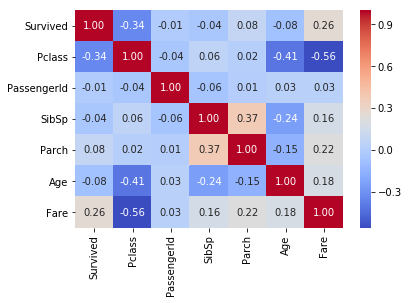

In [34]:
# PassengerId      int64
# Pclass           int64
# SibSp            int64
# Parch            int64
# Survived       float64
# Age            float64
# Fare           float64

g = sns.heatmap(df_raw[["Survived","Pclass", "PassengerId", "SibSp","Parch","Age","Fare"]].corr(),annot=True, fmt = ".2f", cmap = "coolwarm")

At first it appears that "Fare" and "Pclass" are the best indicators. This should not rule out investigation of the other features, but gives us a good place to start.  

#### Fare
As a good first example, we will simply examine the relationship between this feature and the goal predictee.

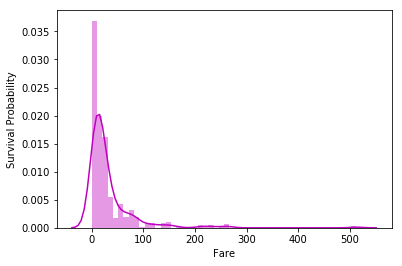

In [54]:
g = sns.distplot(df_raw_train["Fare"], color="m")
g.set(ylabel="Survival Probability");


There is a fairly extreme skew to this data, we can assist our classifier by reducing this skew.

In [55]:
df_raw["logFare"] = df_raw.Fare.apply(lambda x: np.log(x) if x > 0 else 0)

g = sns.distplot(df_raw["logFare"], color="m")
g.set(ylabel="Survival Probability");

AttributeError: 'DataFrame' object has no attribute 'Fare'

#### Pclass
Nothing to do here, the data is already well categorised and there are no missing values. Good old 1900s British class systems, of course it's sorted.

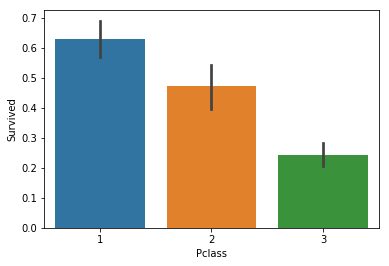

In [83]:
g = sns.barplot(x="Pclass", y="Survived", data=df_raw_train)

#### SibSp and Parch
Something to do with family size?

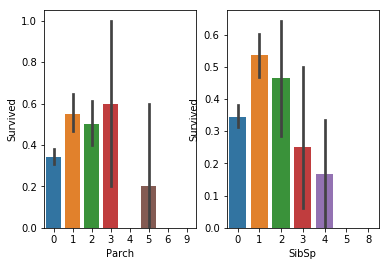

In [82]:
plt.figure()
plt.subplot(1,2,1)
sns.barplot('Parch', 'Survived',data=df_raw)
plt.subplot(1,2,2)
sns.barplot('SibSp','Survived',data=df_raw);

## Convert Names to Titles
An obvious contender for making the "Name" feature usable is to extract the titles from the names, as these are the only generalisable component. 


In [ ]:
def get_unique_titles(names):
    unique_titles = []
    for name in names:
        title = get_title_from_name(name)
        if title not in unique_titles:
            unique_titles.append(title)
    return unique_titles

def get_title_from_name(name):
    return name.split(',')[1].split('.')[0].strip()

In [200]:
all_names = df_raw_train.Name.append(df_raw_test.Name)
titles = get_unique_titles(all_names)

title_mapping = {
    'Mr' : 2,
    'Mrs' : 1,
    'Miss' : 1,
    'Master' : 0,
    'Don' : 3,
    'Rev' : 3,
    'Dr' : 3,
    'Mme' : 1,
    'Ms' : 1,
    'Major' : 3,
    'Lady' : 3,
    'Sir' : 3,
    'Mlle' : 3,
    'Col' : 3,
    'Capt' : 3,
    'the Countess' : 3,
    'Jonkheer' : 3,
    'Dona' : 3
}

df_raw_train['Title'] = df_raw_train.Name.apply(get_title_from_name)
df_raw_train.Title = df_raw_train.Title.apply(lambda x: title_mapping[x])

df_raw_test['Title'] = df_raw_test.Name.apply(get_title_from_name)
df_raw_test.Title = df_raw_test.Title.apply(lambda x: title_mapping[x])


In [201]:
df_raw_train = df_raw_train.drop(["Name"], axis=1)
df_raw_test = df_raw_test.drop(["Name"], axis=1)

For each title in title mapping we want to find the mean age excluding NaNs and then replace all NaNs with that age.

In [202]:
df_raw_train.groupby(['Title','Sex']).Age.mean()

Title  Sex   
0      male       4.574167
1      female    27.765625
2      male      32.368090
3      female    35.600000
       male      45.894737
Name: Age, dtype: float64

In [203]:
df_raw_train.Age.mean()

29.69911764705882

In [204]:
def replace_null_ages_with_mean(cols):
    age = cols[0]
    title = cols[1]
    sex = cols[2]
    if pd.isnull(age):
        if title == 0:
            return 5
        elif title == 1:
            return 28
        elif title == 2:
            return 32
        elif title == 3 and sex == 'female':
            return 36 
        elif title == 3 and sex == 'male':
            return 46
        else:
            return 30
    else:
        return age

    

In [205]:
df_raw_train.Age = df_raw_train[["Age", "Title", "Sex"]].apply(replace_null_ages_with_mean, axis=1)
df_raw_test.Age = df_raw_test[["Age", "Title", "Sex"]].apply(replace_null_ages_with_mean, axis=1)

## Cabin
If there is no cabin we should mark as an 'X' but otherwise strip it to the first character

In [206]:
def replace_cabins_with_level(cabin):
    if pd.isnull(cabin):
        return 'X'
    else:
        return cabin[0]

In [207]:
df_raw_train.Cabin = df_raw_train.Cabin.apply(replace_cabins_with_level)
df_raw_test.Cabin = df_raw_test.Cabin.apply(replace_cabins_with_level)

In [208]:
# g = sns.catplot(x="Cabin", y="Survived", data=df_raw_train, kind='bar')

## Embarked
Perhaps where they got on

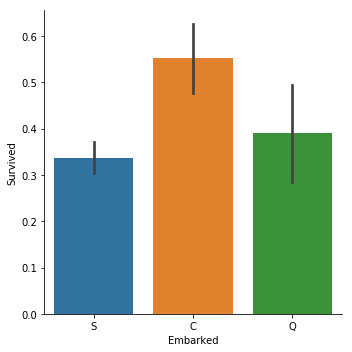

In [209]:
g = sns.catplot(x="Embarked", y="Survived", data=df_raw_train, kind='bar')

In [210]:
def replace_embarked_null(embarked):
    if pd.isnull(embarked):
        return 'X'
    else:
        return embarked

In [211]:
df_raw_train.Embarked = df_raw_train.Embarked.apply(replace_embarked_null)
df_raw_test.Embarked = df_raw_test.Embarked.apply(replace_embarked_null)

## Family

In [212]:
df_raw_train["FamilySz"] = df_raw_train.Parch + df_raw_train.SibSp
df_raw_test["FamilySz"] = df_raw_test.Parch + df_raw_test.SibSp

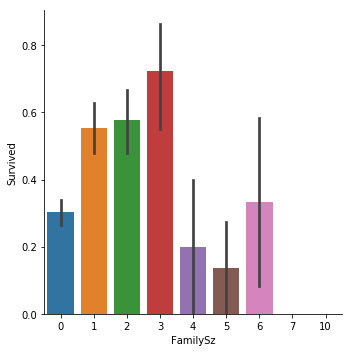

In [213]:
g = sns.catplot(x="FamilySz", y="Survived", data=df_raw_train, kind='bar')

In [214]:
def categorise_family_size(family_size):
    mapping = {
        'Single' : 0,
        'Small' : 1,
        'Large' : 2
    }
    if family_size == 0:
        return mapping['Single']
    elif family_size > 0 and family_size < 4:
        return mapping['Small']
    elif family_size >= 4:
        return mapping['Large']

In [215]:
df_raw_train.FamilySz = df_raw_train.FamilySz.apply(categorise_family_size)
df_raw_test.FamilySz = df_raw_test.FamilySz.apply(categorise_family_size)

## Fares


In [216]:
def fill_nan_fares(fare):
    if np.isnan(fare):
        return 32.204207968574636
    else:
        return fare

In [217]:
df_raw_test.Fare.isnull().sum()

1

In [218]:
mean_fare = (df_raw_train.Fare.mean()); mean_fare

32.204207968574636

In [219]:
df_raw_test["Fare"] = df_raw_test.Fare.apply(fill_nan_fares)

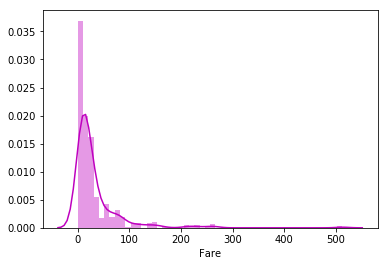

In [220]:
g = sns.distplot(df_raw_train["Fare"], color="m", label="Skewness : %.2f"%(df_raw_train["Fare"].skew()))

In [221]:
df_raw_train["logFare"] = df_raw_train.Fare.apply(lambda x: np.log(x) if x > 0 else 0)
df_raw_test["logFare"] = df_raw_test.Fare.apply(lambda x: np.log(x) if x > 0 else 0)

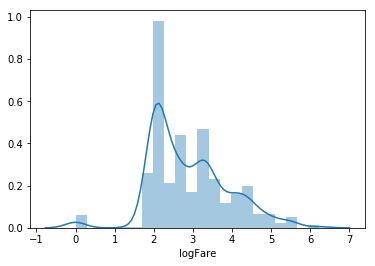

In [222]:
plt.figure()
g = sns.distplot(df_raw_train["logFare"], label="Skewness : %.2f"%(df_raw_train["logFare"].skew()))

## Age

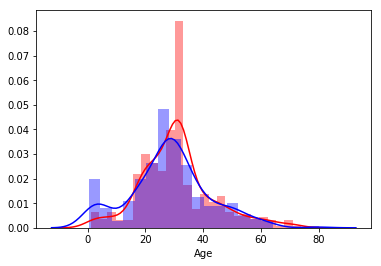

In [223]:
plt.figure()
f = sns.distplot(df_raw_train[df_raw_train.Survived==0].Age, color="red")
g = sns.distplot(df_raw_train[df_raw_train.Survived==1].Age, color="blue")

## Ticket Type

<Figure size 432x288 with 0 Axes>

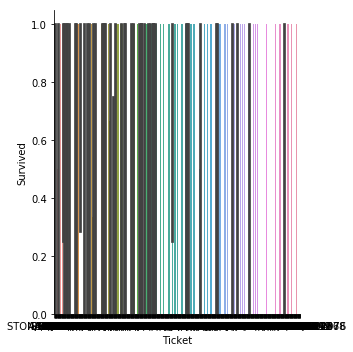

In [224]:
plt.figure()
g = sns.catplot(x="Ticket", y="Survived", data=df_raw_train, kind='bar')

In [225]:
df_raw_train.Ticket.head()

0           A/5 21171
1            PC 17599
2    STON/O2. 3101282
3              113803
4              373450
Name: Ticket, dtype: object

In [226]:
def strip_ticket(Ticket):
    if Ticket.isdigit():
        return "X"
    else:
        return Ticket.replace("/","").replace(".","").strip().split(" ")[0]

In [227]:
df_raw_train["strippedTicket"] = df_raw_train.Ticket.apply(lambda x: strip_ticket(x))
df_raw_test["strippedTicket"] = df_raw_test.Ticket.apply(lambda x: strip_ticket(x))

<Figure size 432x288 with 0 Axes>

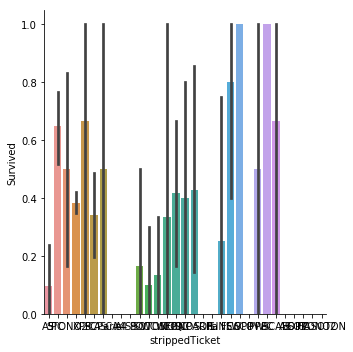

In [228]:
plt.figure()
g = sns.catplot(x="strippedTicket", y="Survived", data=df_raw_train, kind='bar')

## Reflect on changes

In [229]:
df_raw_train.isnull().sum()

PassengerId       0
Survived          0
Pclass            0
Sex               0
Age               0
SibSp             0
Parch             0
Ticket            0
Fare              0
Cabin             0
Embarked          0
Title             0
FamilySz          0
logFare           0
strippedTicket    0
dtype: int64

In [230]:
df_raw_test.isnull().sum()

PassengerId       0
Pclass            0
Sex               0
Age               0
SibSp             0
Parch             0
Ticket            0
Fare              0
Cabin             0
Embarked          0
Title             0
FamilySz          0
logFare           0
strippedTicket    0
dtype: int64

In [231]:
df_raw_train.drop(labels = ["PassengerId","SibSp", "Parch", "Ticket"], axis=1, inplace=True)
df_raw_test.drop(labels = ["PassengerId","SibSp", "Parch", "Ticket"], axis=1, inplace=True)

In [232]:
df_raw_train = pd.get_dummies(df_raw_train)
df_raw_test = pd.get_dummies(df_raw_test)

In [233]:
RF=RandomForestClassifier()
PRF=[{'n_estimators':[10,100],'max_depth':[3,6],'criterion':['gini','entropy']}]
GSRF=GridSearchCV(estimator=RF, param_grid=PRF, scoring='accuracy', cv=2)

In [234]:
xtrain=df_raw_train.drop("Survived",axis=1)
ytrain=df_raw_train['Survived']

xtest=df_raw_test

In [235]:
scores_rf=cross_val_score(GSRF,xtrain,ytrain,scoring='accuracy', cv=5)

In [236]:
model = GSRF.fit(xtrain, ytrain)

In [237]:
pred=model.predict(xtest)

ValueError: Number of features of the model must match the input. Model n_features is 52 and input n_features is 47 

In [ ]:
output=pd.DataFrame({'PassengerId':test2['PassengerId'],'Survived':pred})